# **Proof of concept**

## Use case

### EuroSAT dataset

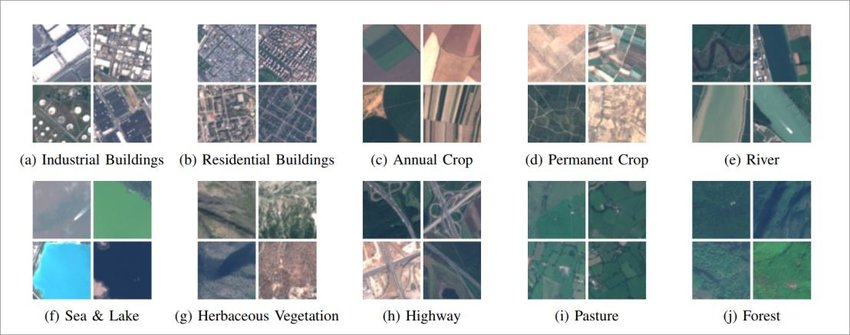

### Loading Data

In [ ]:
pip install -r ./requirements.txt

In [1]:
from dataset import EurosatDataset
dset = EurosatDataset(is_train=False, seed=42, download=False)
print(len(dset))
print(dset.label_encoding)

Test images are reading..: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it, category=SeaLake]            


5400
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### Model

In [ ]:
from model import Classifier
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier().to(device)

Let's look at the summary of our model architecture and make sure that it is in the planned structure.

In [3]:
print(model.summarize())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

### Training

* Data is divided into 2 parts for testing and training.
* The model is created with the specified config values.
* During the desired eopch number, firstly, after the training, the test is performed and the results are recorded.
* The model with the highest result is saved as 'model_best.pth'.

!python train.py  --dropout 0.0 to train the model.
The training logs are accessible in the logs text file.

In [19]:
model.load_state_dict(torch.load("./saved_models/model_best.pth", map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

In [96]:
import numpy as np
from PIL import Image
input_img = np.array(Image.open("./sample.jpg"))
# Définir les dimensions des morceaux
largeur, hauteur, chaine = input_img.shape
taille_morceau = 64

### Division and prediction on the image

In [28]:
def divise_predict_image(input_img):

  results = []
  im = []
  compt = 0

  # Découper l'image en des morceaux de taille (64, 64, 3)
  for x in range(0, largeur, taille_morceau):
      for y in range(0, hauteur, taille_morceau):
          compt +=1
          box = (x, y, x + taille_morceau, y + taille_morceau)
          morceau = input_img[box[0]:box[2],box[1]:box[3],:]
          result = model.predict(morceau)

          results.append(result)
  
  return results

In [29]:
results = divise_predict_image(input_img)

### Generate the necessary masks

In [30]:
Routes = np.zeros((largeur, hauteur))
i = 0
for x in range(0, largeur, taille_morceau):
    for y in range(0, hauteur, taille_morceau):
      box = (x, y, x + taille_morceau, y + taille_morceau)

      Routes[box[0]:box[2],box[1]:box[3]] = results[i][0]['Highway']
      i += 1

In [31]:
Forest = np.zeros((largeur, hauteur))
i = 0
for x in range(0, largeur, taille_morceau):
    for y in range(0, hauteur, taille_morceau):
      box = (x, y, x + taille_morceau, y + taille_morceau)

      Forest[box[0]:box[2],box[1]:box[3]] = results[i][0]['Forest']
      i += 1

In [32]:
Herbes = np.zeros((largeur, hauteur))
i = 0
for x in range(0, largeur, taille_morceau):
    for y in range(0, hauteur, taille_morceau):
      box = (x, y, x + taille_morceau, y + taille_morceau)

      Herbes[box[0]:box[2],box[1]:box[3]] = results[i][0]['HerbaceousVegetation']
      i += 1

In [33]:
Residential = np.zeros((largeur, hauteur))
i = 0
for x in range(0, largeur, taille_morceau):
    for y in range(0, hauteur, taille_morceau):
      box = (x, y, x + taille_morceau, y + taille_morceau)

      Residential[box[0]:box[2],box[1]:box[3]] = results[i][0]['Residential']
      i += 1

In [146]:
veg = np.load("./data/veg.npy").sum(axis=2)
soil = np.load("./data/soil.npy").sum(axis=2)
ndvi = np.load("./data/ndvi.npy")
water = np.load("./data/water.npy").sum(axis=2)
moist = np.load("./data/moist.npy").sum(axis=2)
ice = np.load("./data/ice.npy").sum(axis=2)
slope = np.load("./data/slope.npy")

### Scale the masks

In [147]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)) # Scale to range [0, 1]

# Scale the arrays
Forest_scaled = scaler.fit_transform(Forest.reshape(-1, 1)).reshape(Forest.shape)
Routes_scaled = scaler.fit_transform(Routes.reshape(-1, 1)).reshape(Routes.shape)
Residential_scaled = scaler.fit_transform(Residential.reshape(-1, 1)).reshape(Residential.shape)
Herbes_scaled = scaler.fit_transform(Herbes.reshape(-1, 1)).reshape(Herbes.shape)
soil_scaled = scaler.fit_transform(soil.reshape(-1, 1)).reshape(soil.shape)
ndvi_scaled = scaler.fit_transform(ndvi.reshape(-1, 1)).reshape(ndvi.shape)
water_scaled = scaler.fit_transform(water.reshape(-1, 1)).reshape(water.shape)
moist_scaled = scaler.fit_transform(moist.reshape(-1, 1)).reshape(moist.shape)
ice_scaled = scaler.fit_transform(ice.reshape(-1, 1)).reshape(ice.shape)
slope_scaled = scaler.fit_transform(slope.reshape(-1, 1)).reshape(slope.shape)

In [167]:
veg

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Generate the graph

### Safest road with longer distance

In [148]:
import rasterio
import numpy as np
import networkx as nx
from scipy.ndimage import gaussian_filter
from skimage import filters


# Calculer une carte de coût de déplacement en utilisant des données d'élévation et de végétation
cost_map = slope_scaled + Forest_scaled  - Routes_scaled  + Residential_scaled  + Herbes_scaled  + veg_scaled  - soil_scaled  + ndvi_scaled  + water_scaled  + moist_scaled  + ice_scaled 

# Appliquer un flou gaussien pour lisser la carte de coût de déplacement
cost_map = gaussian_filter(cost_map, sigma=2)

# Appliquer un filtre de Sobel pour obtenir la carte de gradient
gradient_map = filters.sobel(cost_map)

# Créer un graph basé sur la carte de gradient
G = nx.Graph()
rows, cols = largeur, hauteur
for r in range(rows):
    for c in range(cols):
        if gradient_map[r, c] > 0:
            G.add_node((r, c))
            if r > 0 and gradient_map[r-1, c] > 0:
                G.add_edge((r, c), (r-1, c), weight=gradient_map[r-1, c])
            if c > 0 and gradient_map[r, c-1] > 0:
                G.add_edge((r, c), (r, c-1), weight=gradient_map[r, c-1])
            if r < rows - 1 and gradient_map[r+1, c] > 0:
                G.add_edge((r, c), (r+1, c), weight=gradient_map[r+1, c])
            if c < cols - 1 and gradient_map[r, c+1] > 0:
                G.add_edge((r, c), (r, c+1), weight=gradient_map[r, c+1])

# Définir les points de départ et d'arrivée
start_point = (100, 100)
end_point = (400, 1100)

# Trouver le chemin le plus court entre les points de départ et d'arrivée en utilisant l'algorithme de Dijkstra
start_node = min(G.nodes, key=lambda n: np.linalg.norm(np.array(n) - np.array(start_point)))
end_node = min(G.nodes, key=lambda n: np.linalg.norm(np.array(n) - np.array(end_point)))
path = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')

# Afficher le chemin le plus court
print("The safest short path is :", path)

The safest short path is : [(100, 100), (101, 100), (102, 100), (102, 101), (102, 102), (102, 103), (103, 103), (103, 104), (104, 104), (105, 104), (105, 105), (106, 105), (107, 105), (107, 106), (107, 107), (107, 108), (107, 109), (107, 110), (107, 111), (107, 112), (107, 113), (106, 113), (106, 114), (106, 115), (106, 116), (106, 117), (106, 118), (106, 119), (106, 120), (106, 121), (107, 121), (107, 122), (107, 123), (107, 124), (107, 125), (107, 126), (107, 127), (107, 128), (107, 129), (107, 130), (107, 131), (106, 131), (106, 132), (106, 133), (106, 134), (105, 134), (105, 135), (105, 136), (105, 137), (104, 137), (104, 138), (104, 139), (105, 139), (105, 140), (105, 141), (105, 142), (105, 143), (106, 143), (107, 143), (108, 143), (108, 144), (109, 144), (110, 144), (110, 145), (111, 145), (111, 146), (112, 146), (113, 146), (114, 146), (115, 146), (115, 147), (115, 148), (115, 149), (115, 150), (116, 150), (117, 150), (118, 150), (119, 150), (120, 150), (121, 150), (122, 150), 

### Shortest distance with a risky road

In [149]:
import rasterio
import numpy as np
import networkx as nx
from scipy.ndimage import gaussian_filter
from skimage import filters


# Calculer une carte de coût de déplacement en utilisant des données d'élévation et de végétation
cost_map = slope_scaled + Forest_scaled  - Routes_scaled  + Residential_scaled  + Herbes_scaled  + veg_scaled  - soil_scaled  + ndvi_scaled  + water_scaled  + moist_scaled  + ice_scaled 

# Appliquer un flou gaussien pour lisser la carte de coût de déplacement
cost_map = gaussian_filter(cost_map, sigma=2)

# Appliquer un filtre de Sobel pour obtenir la carte de gradient
gradient_map = filters.sobel(cost_map)

# Définir les points de départ et d'arrivée
start_point = (100, 100)
end_point = (400, 1100)

dist_est = math.sqrt((end_point[0]-start_point[0])**2 + (end_point[1]-start_point[1])**2)

# Créer un graph basé sur la carte de gradient avec des poids qui prennent en compte la distance totale
G = nx.Graph()
rows, cols = largeur, hauteur
for r in range(rows):
    for c in range(cols):
        if gradient_map[r, c] > 0:
            G.add_node((r, c))
            if r > 0 and gradient_map[r-1, c] > 0:
                dist = np.linalg.norm(np.array((r-1, c)) - np.array(start_point))
                G.add_edge((r, c), (r-1, c), weight=gradient_map[r-1, c]/11+2*dist/dist_est)
            if c > 0 and gradient_map[r, c-1] > 0:
                dist = np.linalg.norm(np.array((r, c-1)) - np.array(start_point))
                G.add_edge((r, c), (r, c-1), weight=gradient_map[r, c-1]/11+2*dist/dist_est)
            if r < rows - 1 and gradient_map[r+1, c] > 0:
                dist = np.linalg.norm(np.array((r+1, c)) - np.array(start_point))
                G.add_edge((r, c), (r+1, c), weight=gradient_map[r+1, c]/11+2*dist/dist_est)
            if c < cols - 1 and gradient_map[r, c+1] > 0:
                dist = np.linalg.norm(np.array((r, c+1)) - np.array(start_point))
                G.add_edge((r, c), (r, c+1), weight=gradient_map[r, c+1]/11+2*dist/dist_est)


# Trouver le chemin le plus court entre les points de départ et d'arrivée en utilisant l'algorithme de Dijkstra
start_node = min(G.nodes, key=lambda n: np.linalg.norm(np.array(n) - np.array(start_point)))
end_node = min(G.nodes, key=lambda n: np.linalg.norm(np.array(n) - np.array(end_point)))

# Trouver le chemin le plus court entre les points de départ et d'arrivée en utilisant l'algorithme de Dijkstra
path2 = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')

# Afficher le chemin le plus court
print("The shortest path is :", path2)

The shortest path is : [(100, 100), (101, 100), (101, 101), (102, 101), (102, 102), (102, 103), (103, 103), (103, 104), (104, 104), (105, 104), (105, 105), (106, 105), (107, 105), (107, 106), (107, 107), (107, 108), (107, 109), (107, 110), (107, 111), (107, 112), (107, 113), (107, 114), (108, 114), (109, 114), (110, 114), (111, 114), (112, 114), (113, 114), (114, 114), (115, 114), (115, 115), (115, 116), (115, 117), (115, 118), (115, 119), (115, 120), (116, 120), (117, 120), (118, 120), (119, 120), (120, 120), (121, 120), (122, 120), (122, 121), (122, 122), (122, 123), (122, 124), (122, 125), (122, 126), (122, 127), (122, 128), (122, 129), (122, 130), (122, 131), (122, 132), (122, 133), (122, 134), (123, 134), (124, 134), (125, 134), (125, 135), (126, 135), (127, 135), (128, 135), (129, 135), (129, 136), (130, 136), (131, 136), (132, 136), (132, 137), (133, 137), (134, 137), (135, 137), (135, 138), (136, 138), (137, 138), (137, 139), (138, 139), (139, 139), (139, 140), (140, 140), (140

In [157]:
Forest_scaled

array([[0.33333333, 0.33333333, 0.33333333, ..., 0.19444444, 0.19444444,
        0.19444444],
       [0.33333333, 0.33333333, 0.33333333, ..., 0.19444444, 0.19444444,
        0.19444444],
       [0.33333333, 0.33333333, 0.33333333, ..., 0.19444444, 0.19444444,
        0.19444444],
       ...,
       [0.26388889, 0.26388889, 0.26388889, ..., 0.20833333, 0.20833333,
        0.20833333],
       [0.26388889, 0.26388889, 0.26388889, ..., 0.20833333, 0.20833333,
        0.20833333],
       [0.26388889, 0.26388889, 0.26388889, ..., 0.20833333, 0.20833333,
        0.20833333]])

### Minimum slope path

In [152]:
import rasterio
import numpy as np
import networkx as nx
from scipy.ndimage import gaussian_filter
from skimage import filters


# Calculer une carte de coût de déplacement en utilisant des données d'élévation et de végétation
cost_map = slope_scaled

# Appliquer un flou gaussien pour lisser la carte de coût de déplacement
cost_map = gaussian_filter(cost_map, sigma=2)

# Appliquer un filtre de Sobel pour obtenir la carte de gradient
gradient_map = filters.sobel(cost_map)

# Définir les points de départ et d'arrivée
start_point = (100, 100)
end_point = (400, 1100)

dist_est = math.sqrt((end_point[0]-start_point[0])**2 + (end_point[1]-start_point[1])**2)

# Créer un graph basé sur la carte de gradient avec des poids qui prennent en compte la distance totale
G = nx.Graph()
rows, cols = largeur, hauteur
for r in range(rows):
    for c in range(cols):
        if gradient_map[r, c] > 0:
            G.add_node((r, c))
            if r > 0 and gradient_map[r-1, c] > 0:
                dist = np.linalg.norm(np.array((r-1, c)) - np.array(start_point))
                G.add_edge((r, c), (r-1, c), weight=gradient_map[r-1, c])
            if c > 0 and gradient_map[r, c-1] > 0:
                dist = np.linalg.norm(np.array((r, c-1)) - np.array(start_point))
                G.add_edge((r, c), (r, c-1), weight=gradient_map[r, c-1])
            if r < rows - 1 and gradient_map[r+1, c] > 0:
                dist = np.linalg.norm(np.array((r+1, c)) - np.array(start_point))
                G.add_edge((r, c), (r+1, c), weight=gradient_map[r+1, c])
            if c < cols - 1 and gradient_map[r, c+1] > 0:
                dist = np.linalg.norm(np.array((r, c+1)) - np.array(start_point))
                G.add_edge((r, c), (r, c+1), weight=gradient_map[r, c+1])


# Trouver le chemin le plus court entre les points de départ et d'arrivée en utilisant l'algorithme de Dijkstra
start_node = min(G.nodes, key=lambda n: np.linalg.norm(np.array(n) - np.array(start_point)))
end_node = min(G.nodes, key=lambda n: np.linalg.norm(np.array(n) - np.array(end_point)))

# Trouver le chemin le plus court entre les points de départ et d'arrivée en utilisant l'algorithme de Dijkstra
path3 = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')

# Afficher le chemin le plus court
print("The path with minimum slope is :", path2)

NetworkXNoPath: No path between (100, 100) and (501, 1167).

In [ ]:
import matplotlib.pyplot as plt

# Plot the image with the path drawn on it
fig, ax = plt.subplots()
ax.imshow(input_img, cmap='gray')
nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=42), edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], ax=ax, edge_color='r')
ax.scatter(start_point[1], start_point[0], s=50, c='g', marker='o', label='Start')
ax.scatter(end_point[1], end_point[0], s=50, c='r', marker='o', label='End')
ax.legend()
plt.show()

### This cell takes less time to run to generate a visualisation

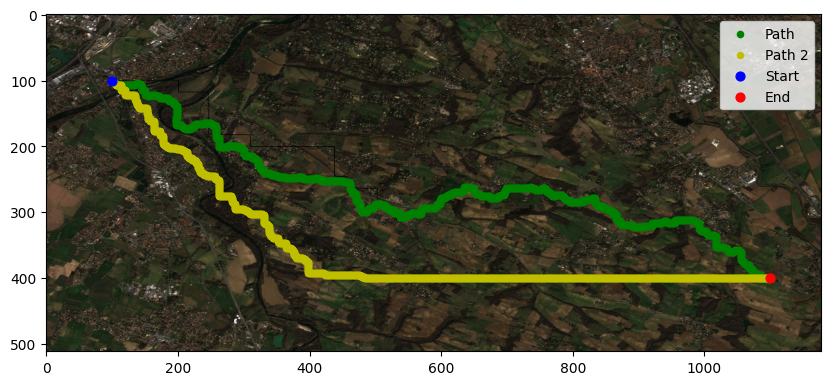

In [150]:
# Plot the image with the path drawn on it
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(input_img)
ax.scatter(path[0][1], path[0][0], s=20, c='g', marker='o',label='Path')
ax.scatter(path2[0][1], path2[0][0], s=20, c='y', marker='o',label='Path 2')
for i in range(1,len(path)):
    ax.scatter(path[i][1], path[i][0], s=20, c='g', marker='o')

for i in range(1,len(path2)):
    ax.scatter(path2[i][1], path2[i][0], s=20, c='y', marker='o')

ax.scatter(start_point[1], start_point[0], s=40, c='b', marker='o', label='Start')
ax.scatter(end_point[1], end_point[0], s=40, c='r', marker='o', label='End')
ax.legend()
plt.show()